In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [4]:
flags = pd.read_feather('../data/all_flags.feather')
tf_idf = pd.read_feather('../data/flag_description_tf_idf.feather')

In [16]:
data = pd.DataFrame({'flag-country': flags.apply(lambda r: f'{r['Flag(s)']}-{r['State']}', axis=1)}).join(tf_idf)
data

,flag-country,white,with,a,black,,shahada,in,thuluth,script,...,tiara,base,zimbabwe,dexter,hand,appaumé,kosovo,arrayed,slight,outline
0,Afghanistan (Islamic Emirate)-Afghanistan,0.020678,0.026676,0.022755,0.088128,0.0,0.266417,0.079238,0.291759,0.248437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,Afghanistan (Islamic Republic)-Afghanistan,0.008070,0.010410,0.000000,0.034391,0.0,0.000000,0.015461,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,Albania-Albania,0.000000,0.032832,0.028006,0.108465,0.0,0.000000,0.048762,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,Algeria-Algeria,0.010339,0.000000,0.022755,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,Andorra-Andorra,0.000000,0.008369,0.000000,0.000000,0.0,0.000000,0.012429,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Somaliland-Somaliland,0.026120,0.000000,0.019162,0.037107,0.0,0.112176,0.033363,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
209,South Ossetia-South Ossetia,0.022057,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
210,Taiwan-Taiwan,0.015039,0.038802,0.033098,0.000000,0.0,0.000000,0.028814,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
211,Transnistria-Transnistria,0.000000,0.009485,0.024272,0.000000,0.0,0.000000,0.014087,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11914


In [18]:
X = data[data.columns.drop('flag-country')]
Y = data['flag-country']

In [38]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)

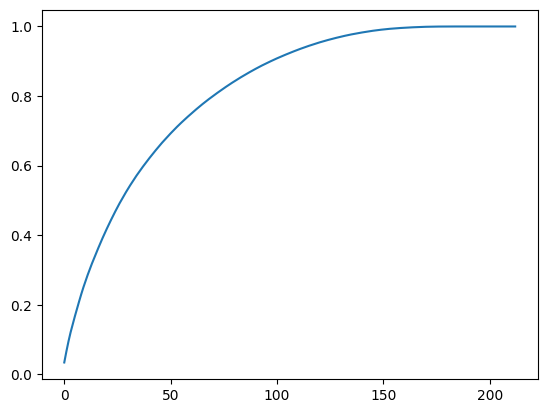

In [42]:
fig, ax = plt.subplots()

cum_var = np.cumsum(pca.explained_variance_ratio_)
ax.plot(cum_var)

plt.show()

In [72]:
all_var = np.argmin(cum_var < 1)
all_var

np.int64(186)

In [81]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline

pipe = make_pipeline(
    PCA(n_components=all_var),
    KMeans(n_clusters=7)
)

pipe.fit(X, Y)
labels = pipe.predict(X)
categories = {label: Y[labels == label].values for label in np.unique(labels)}
categories

{np.int32(0): array(['Micronesia-Micronesia'], dtype=object),
 np.int32(1): array(['Lebanon-Lebanon'], dtype=object),
 np.int32(2): array(['Argentina-Argentina', 'Azerbaijan-Azerbaijan',
        'Maldives-Maldives', 'Mauritania-Mauritania',
        'North Macedonia-North Macedonia', 'Pakistan-Pakistan',
        'Turkey-Turkey', 'Northern Cyprus-Northern Cyprus'], dtype=object),
 np.int32(3): array(['Afghanistan (Islamic Emirate)-Afghanistan', 'Albania-Albania',
        'Bangladesh-Bangladesh', 'Botswana-Botswana', 'Japan-Japan',
        'Morocco-Morocco', 'Nauru-Nauru', 'Palau-Palau',
        'Saudi Arabia-Saudi Arabia', 'Somalia-Somalia',
        'Switzerland-Switzerland', 'Tunisia-Tunisia', 'Vietnam-Vietnam'],
       dtype=object),
 np.int32(4): array(['Bahrain-Bahrain', 'Bhutan-Bhutan',
        'Democratic Republic of the Congo-Democratic Republic of the Congo',
        'Republic of the Congo-Republic of the Congo', 'Cyprus-Cyprus',
        'Denmark-Denmark', 'Eritrea-Eritrea', 'Fin